In [ ]:
!pip install transformers datasets gradio matplotlib

In [ ]:
from transformers import pipeline

Load a sentiment analysis pipeline

In [ ]:
sentiment = pipeline("sentiment-analysis")

Testing on some sample reviews

In [ ]:
reviews = [
    "I love this phone! Battery life is amazing.",
    "The product was terrible. I want a refund!",
    "It's okay, not the best but not the worst either."
]

results = sentiment(reviews)

for review, result in zip(reviews, results):
    print(f"Review: {review}")
    print(f"Sentiment: {result['label']} (Score: {result['score']:.2f})\n")

Review: I love this phone! Battery life is amazing.
Sentiment: POSITIVE (Score: 1.00)

Review: The product was terrible. I want a refund!
Sentiment: NEGATIVE (Score: 1.00)

Review: It's okay, not the best but not the worst either.
Sentiment: POSITIVE (Score: 0.97)



The default model only has 2 labels, "Positive" and "Negative". The last example review is "Neutral", but a Positive score can be misleading. So let's use a different model, RoBERTa 3 class, that gives scores for 3 classes. But this class does not have the labels mapped, so we have to map the lables to the scores and do some additional steps since this model is not pre-wrapped in a pipeline

In [5]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch

We load the model and Tokenizer since we will be tokenizing the input

In [ ]:
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [7]:
labels = ['negative', 'neutral', 'positive']
reviews = [
    "I love this phone! Battery life is amazing.",
    "The product was terrible. I want a refund!",
    "It's okay, not the best but not the worst either."
]

Now, we will be tokenizing the input and run it through the model. SInce the output of this model are raw logits, we need to convert them into probabilities, so we will be using softmax function. Then we find the label with the highest scores and assign

In [8]:
for review in reviews:
    # Tokenize
    encoded_input = tokenizer(review, return_tensors='pt')

    # Get model output
    with torch.no_grad():  #we're not doing any training here, so we don't need to calculate any gradients, saving time
        output = model(**encoded_input)

    # Convert logits to probabilities
    scores = softmax(output.logits.numpy()[0])

    # Find the label with highest score
    max_score_idx = scores.argmax()
    sentiment = labels[max_score_idx]

    print(f"Review: {review}")
    print(f"Sentiment: {sentiment} (Confidence: {scores[max_score_idx]:.2f})\n")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Review: I love this phone! Battery life is amazing.
Sentiment: positive (Confidence: 0.99)

Review: The product was terrible. I want a refund!
Sentiment: negative (Confidence: 0.98)

Review: It's okay, not the best but not the worst either.
Sentiment: neutral (Confidence: 0.51)



The example reviews were handled very well. Now, we'll be using the 'amazon_polarity' dataset and performing this sentiment analysis on them. This dataset has 2 classes, but we'll see if we can use our 3 class model for this

In [ ]:
from datasets import load_dataset

dataset = load_dataset("amazon_polarity", split="train")

In [10]:
# Preview first 5 rows
for i in range(5):
    print(f"Title: {dataset[i]['title']}")
    print(f"Content: {dataset[i]['content']}")
    print(f"Label: {dataset[i]['label']}")  # 1 = Positive, 0 = Negative
    print("-" * 80)

Title: Stuning even for the non-gamer
Content: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^
Label: 1
--------------------------------------------------------------------------------
Title: The best soundtrack ever to anything.
Content: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this

For the sake of simplicity, we'll take 100 random samples from this dataset and try our model on this (tqdm is just to show a progress bar, doesn't do anything with the model)

In [11]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [12]:
sample_reviews = dataset.shuffle(seed=42).select(range(100))

In [13]:
sentiment_counts = {'positive': 0, 'neutral': 0, 'negative': 0} #this is initial counts, we'll count each score and use this to visually see the counts

In [ ]:
for item in tqdm(sample_reviews):
    review_text = item['content']

    # Tokenize
    encoded_input = tokenizer(review_text, return_tensors='pt', truncation=True, max_length=512)

    # Predict
    with torch.no_grad():
        output = model(**encoded_input)
    scores = softmax(output.logits.numpy()[0])
    max_idx = scores.argmax()
    predicted_label = labels[max_idx]

    # Count
    sentiment_counts[predicted_label] += 1

In [16]:
print("\nSentiment Distribution:")
for sentiment, count in sentiment_counts.items():
    print(f"{sentiment.capitalize()}: {count}")


Sentiment Distribution:
Positive: 55
Neutral: 18
Negative: 44


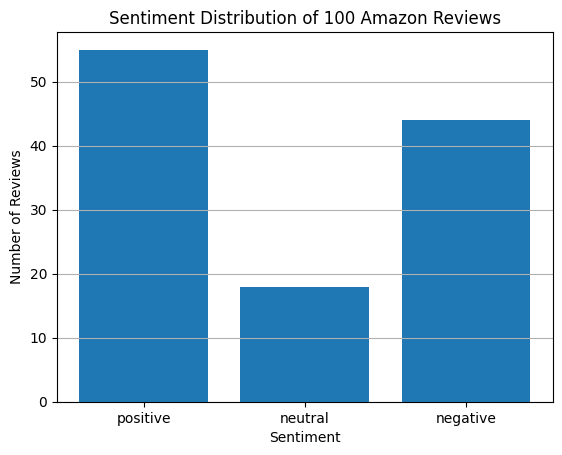

In [17]:
plt.bar(sentiment_counts.keys(), sentiment_counts.values())
plt.title("Sentiment Distribution of 100 Amazon Reviews")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.grid(axis='y')
plt.show()

Now let's use Gradio to let users input their text and see the result

In [ ]:
!pip install gradio

In [ ]:
import gradio as gr
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch

# Load model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
labels = ['negative', 'neutral', 'positive']

# Prediction function
def predict_sentiment(text):
    encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        output = model(**encoded_input)
    scores = softmax(output.logits.numpy()[0])
    top_idx = scores.argmax()
    sentiment = labels[top_idx]
    confidence = round(float(scores[top_idx]), 2)
    return f"Sentiment: {sentiment.capitalize()} (Confidence: {confidence})"

# Gradio UI
demo = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(lines=3, placeholder="Enter a product review: "),
    outputs="text",
    title="Amazon Review Sentiment Analyzer",
    description="Enter a product review to see if it's positive, negative, or neutral."
)

demo.launch(debug=True)

Let's change this a bit more to show all the 3 sentiment scores for a review

In [ ]:
import gradio as gr
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch

# Load model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
labels = ['Negative', 'Neutral', 'Positive']

# Prediction function
def predict_sentiment(text):
    encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        output = model(**encoded_input)
    scores = softmax(output.logits.numpy()[0])

    # Build label -> score dictionary
    result = {label: float(round(score, 4)) for label, score in zip(labels, scores)}

    return result

# Create Gradio Interface
demo = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(lines=4, placeholder="Type a product review here: ", label="Amazon Review"),
    outputs=gr.Label(num_top_classes=3, label="Sentiment Scores"),
    title="Amazon Review Sentiment Analyzer",
    description="This app uses a Hugging Face RoBERTa model to analyze whether a product review is Positive, Neutral, or Negative.",
    theme="default"
)

demo.launch(debug=True)


Now let's also add a feature where a user can upload a CSV file with reviews and can download the results for them

In [ ]:
import gradio as gr
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch

# Load model and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
labels = ['Negative', 'Neutral', 'Positive']

# Function for single review
def analyze_single_review(text):
    encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        output = model(**encoded_input)
    scores = softmax(output.logits.numpy()[0])
    result = {label: round(float(score), 4) for label, score in zip(labels, scores)}
    return result

# Function for CSV upload
def analyze_csv(file):
    df = pd.read_csv(file)

    if 'review' not in df.columns:
        return "❌ Error: CSV must contain a column named 'review'", None

    sentiments = []
    confidences = []

    for review in df['review']:
        encoded_input = tokenizer(str(review), return_tensors='pt', truncation=True, max_length=512)
        with torch.no_grad():
            output = model(**encoded_input)
        scores = softmax(output.logits.numpy()[0])
        pred_idx = scores.argmax()
        sentiments.append(labels[pred_idx])
        confidences.append(round(float(scores[pred_idx]), 4))

    df['Sentiment'] = sentiments
    df['Confidence'] = confidences

    output_path = "sentiment_output.csv"
    df.to_csv(output_path, index=False)

    return df, output_path

# Create Gradio tabs
with gr.Blocks(title="Amazon Review Sentiment Analyzer") as demo:
    gr.Markdown("# 📦 Amazon Review Sentiment Analyzer")
    gr.Markdown("Analyze the sentiment of a single review or upload a CSV file with multiple reviews.")

    with gr.Tab("Single Review"):
        single_input = gr.Textbox(lines=3, placeholder="Type your review here", label="Review")
        single_output = gr.Label(label="Sentiment Scores")
        single_btn = gr.Button("Analyze")
        single_btn.click(analyze_single_review, inputs=single_input, outputs=single_output)

    with gr.Tab("CSV Upload"):
        csv_input = gr.File(label="Upload CSV with a 'review' column")
        csv_table = gr.Dataframe(label="Results Table")
        csv_file = gr.File(label="Download Updated CSV")
        csv_btn = gr.Button("Analyze CSV")
        csv_btn.click(analyze_csv, inputs=csv_input, outputs=[csv_table, csv_file])

demo.launch()
